# Информация о пользователях курса Stepik. 
### Общая цель - найти закономерности и определять пользователей, способных закончить успешно курс на сайте для предоставления определенных привилегий и скидок на другие образовательные программы (по результату анализа поведения юзера за перые 3 дня на сайте)

То есть надо добиться высокого показателя recall, считая positive классом людей, способных закончить курс.
1) Первоначально проанализируем данные, чтобы определить тех, кто из пользователей вообще смог закончить курс. Определим требуемую метрику, по которой будем классифицировать как тех, кто смог закончить курс, а кто нет.\
2) Изучим поведение пользователей за первые 3 дня с момента начала курса. Создадим фичи, по которым будем обучать модель.\
3) Зададим разные модели и определим лучшую по параметру recall

**Дополнительно изучим датасет, чтобы определить id создателя курса и номер задания, который больше всего доставил сложностей и лишил многих мотивации решать курс далее**

In [114]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)}) #задание размера графиков

# Предворительная обработка данных

### Для предворительнойобработки надо найти ключевые параметры про каждого из пользователей курса

In [115]:
events_data=pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/oG0XwOIrrMyQ2w')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [116]:
submissions_data=pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/2xY4JaB5JzrI6w')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


### Перевод времени из unix date:

In [117]:
events_data['date']=pd.to_datetime(events_data.timestamp, unit='s')
events_data['day']=events_data['date'].dt.date
submissions_data['date']=pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day']=submissions_data['date'].dt.date

In [118]:
events_data.head(7)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15


In [119]:
submissions_data.head(7)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15
6,31976,1478852055,correct,15853,2016-11-11 08:14:15,2016-11-11


### Обработка events_data:

In [120]:
events_data.query("action =='passed'").groupby('user_id').count().shape[0]*100/events_data.shape[0] 
#процент людей, решивших хотя бы один номер

0.49593429832996383

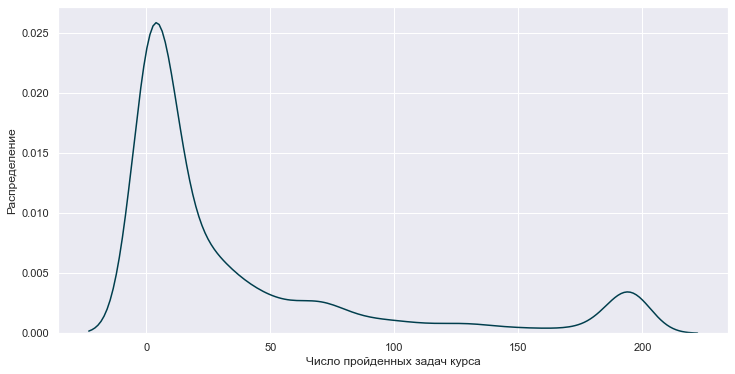

In [121]:
ax = sns.kdeplot(data=events_data.query("action =='passed'").groupby('user_id').count().action,color='#003e4d')
ax.set_xlabel('Число пройденных задач курса')
ax.set_ylabel('Распределение');

In [122]:
x=events_data.groupby(['day','action'],as_index=False).agg({'user_id':'nunique'}).\
                                                        query("action=='viewed'| action=='passed'")
x_v=x.query("action=='viewed'")
x_p=x.query("action=='passed'")

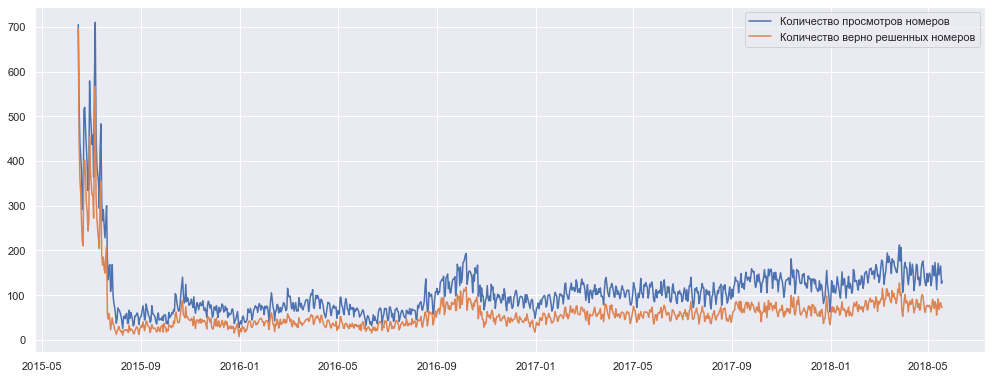

In [123]:
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,1.1,0.8])
ax.plot(x_v['day'],x_v['user_id'])
ax.plot(x_p['day'],x_p['user_id'])
ax.legend(['Количество просмотров номеров', 'Количество верно решенных номеров'])
plt.show()

In [124]:
users_events_data=events_data.pivot_table(index='user_id',columns='action',
                                           values='step_id',aggfunc='count',fill_value=0).reset_index()
users_events_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


Проверка на потерю данных:

In [125]:
def check(df):
    if events_data.user_id.nunique()==df.user_id.nunique():
        print('Пользователи не потеряны')
    else:
        print('Количествопользователй отличается от исходного числа')

### Обработка submissions_data:

In [126]:
users_scores=submissions_data.pivot_table(index='user_id',columns='submission_status',
                                         values='step_id',aggfunc='count',fill_value=0).reset_index()

users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


### Вычисление дат посещений курса пользователями

In [127]:
visits_users_time=events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day']).\
                                            groupby('user_id')['timestamp'].apply(list)
visits_users_time

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

In [128]:
visits_users_time.apply(np.diff)

user_id
1                                                       []
2                                                [4843602]
3         [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                               [33702812]
7                                                       []
                               ...                        
26790                           [238225, 893964, 64879648]
26793                                                   []
26794    [86128, 136759, 94899, 1422583, 14347289, 5050...
26797                                            [1567990]
26798                                                   []
Name: timestamp, Length: 19234, dtype: object

Все значения дельт по времени между заходами: (выражено в днях)

In [129]:
gap_data=visits_users_time.apply(np.diff).values
gap_data=pd.Series(np.concatenate(gap_data,axis=0))
gap_data=gap_data/(24*60*60)

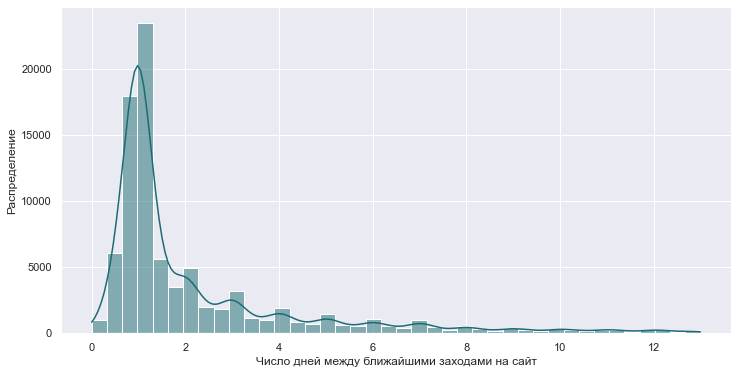

In [130]:
ax = sns.histplot(gap_data[gap_data<13],bins=40, kde=True,color='#1c6b72')
ax.set_xlabel('Число дней между ближайшими заходами на сайт')
ax.set_ylabel('Распределение');

In [131]:
print('95 процентов пользователей между заходами на курс длают интервал не более ',gap_data.quantile(0.95).round(1),' дней')

95 процентов пользователей между заходами на курс длают интервал не более  59.8  дней


In [132]:
#Дата последнего захода на сайт каждого пользоателя
users_data=events_data.groupby('user_id',as_index=False)\
.agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
users_data.head(7)

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
5,8,1481466913
6,9,1484999497


In [133]:
#Последняя дата в данных
last_date=events_data.timestamp.max()
#Считаем, что кикнулся с курса если нет более 30 дней
drop_out_threshold=30*24*60*60
print(last_date,drop_out_threshold)

1526772811 2592000


In [134]:
#Сколько прошло с момента последнего заходадо момента окончания исследования для каждого пользователя
users_data['is_gone_user']=(last_date-users_data.last_timestamp)>drop_out_threshold

In [135]:
#Объединение данных
users_data=users_data.merge(users_scores,how='outer').fillna(0)
users_data.head(7)

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
5,8,1481466913,True,9.0,21.0
6,9,1484999497,True,0.0,0.0


In [136]:
check(users_data)

Пользователи не потеряны


In [137]:
users_data=users_data.merge(users_events_data,how='outer').fillna(0)

In [138]:
#Найдем сколько суммарно дней пользователь побывал на сайте:
users_days=events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data=users_data.merge(users_days,how='outer').fillna(0)
users_data.head(7)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
5,8,1481466913,True,9.0,21.0,109,84,37,156,2
6,9,1484999497,True,0.0,0.0,3,3,0,4,1


In [139]:
check(users_data)

Пользователи не потеряны


### Определим условие успешного завершения курса:

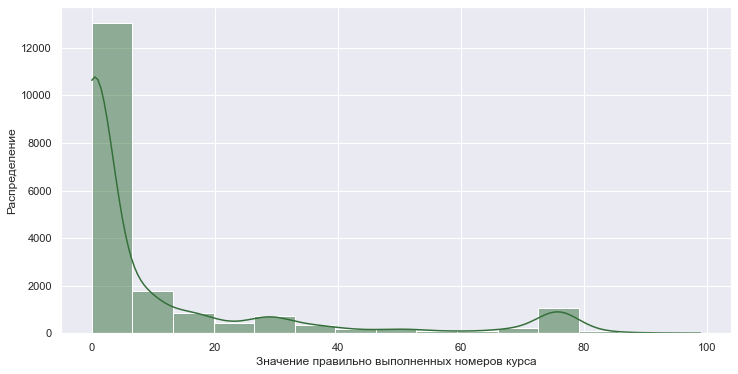

In [140]:
ax = sns.histplot(users_data.correct[users_data.correct<100],bins=15, kde=True,color='#346f39')
ax.set_xlabel('Значение правильно выполненных номеров курса')
ax.set_ylabel('Распределение');

По распределению понятно, что есть те, кто брасают в самом начале, а есть те, кто в итоге доходят до заветного сертификата.\ При этом сертификат выдается не при 100% решенных номеров. Судя по распределению можно сделать вывод, что после 60 номеров появляется всплеск пользователей, которые как раз оказались усердными и прошли до конца. Поэтому, границей между сдавшими и отлетевшими пользователями можно считать число верных номеров, равное 60.

In [141]:
#Проверим прошел ли пользователь курс
users_data['passed_course']=users_data['correct']>60
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


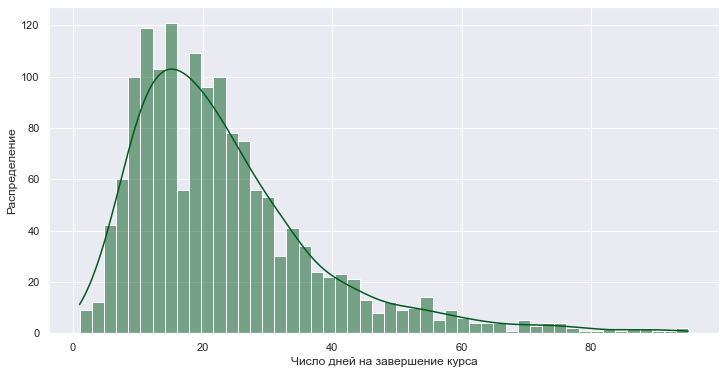

In [142]:
#Сколько надо дней чтобы завершить курс?
day_to_finish=users_data[users_data.passed_course==True].day
ax = sns.histplot(day_to_finish[day_to_finish<100],bins=50, kde=True, color='#02591c')
ax.set_xlabel('Число дней на завершение курса')
ax.set_ylabel('Распределение');

# Поиск создателя курса:

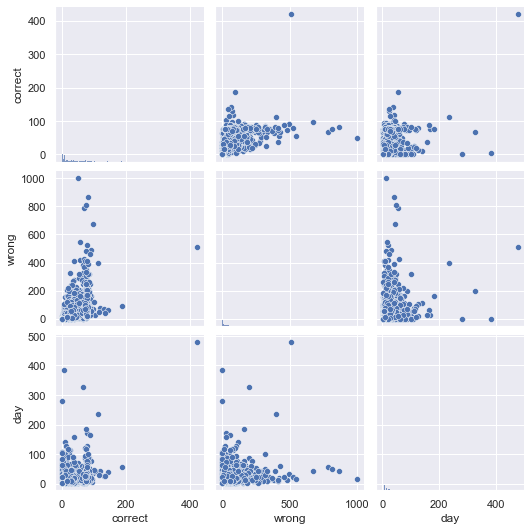

In [143]:
def func(x):
    if x==True:
        return ['passed']
    else:
        return ["didn't pass"]

x=users_data.loc[1:10000,:]
#x['passed_coursess']=x['passed_course']
#x['passed_coursess']=x['passed_coursess'].apply(func)
#x


sns.pairplot(x[['correct','wrong','day']]);

In [144]:
df=users_data.loc[users_data.day>=0.9*users_data.day.max()]
#Определим по необычно высоким значениям дней захода и числу ошибок и верных ответов
df

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
781,1046,1525160857,False,421.0,513.0,128,124,721,8122,478,True


In [145]:
print('Создатель курса под номером id =',int(df.user_id));

Создатель курса под номером id = 1046


## Отберем события пользователей, сделанные впервые 3 дня.
### Целью является определять за 3 первых дня на сайте пройдет ли пользователь весь курс до конца

In [146]:
learning_time_threshold = 3*24*60*60 #3 days

In [147]:
#Даата когда пользователь впервые защел на курс:
user_min_time=events_data.groupby('user_id',as_index=False) \
    .agg({'timestamp':min}).rename({'timestamp':'min_timestamp'}, axis=1)
user_min_time.head(6)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
5,8,1480603427


In [148]:
users_data=users_data.merge(user_min_time,how='outer')
users_data.head(7)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False,1480603427
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False,1484999434


In [149]:
events_data.head(5)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [150]:
#Соединим timestamp (время какой-то операции на сайте) и user_id
events_data['user_time']=events_data.user_id.map(str) + '_' + events_data.timestamp	.map(str)
events_data.head(5)

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [151]:
user_learning_time_threshold=user_min_time.user_id.map(str)+ '_' + \
        (user_min_time.min_timestamp+learning_time_threshold).map(str)
user_learning_time_threshold.head(6)

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
5    8_1480862627
dtype: object

In [152]:
user_min_time['user_learning_time_threshold']=user_learning_time_threshold
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [153]:
events_data=events_data.merge(user_min_time[['user_id','user_learning_time_threshold']],how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [154]:
#Остается просто проверить попадает ли событие в этот самый порог:user_time < или = user_learning_time_threshold
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


## Интересное исследование

Слушатели онлайн курсов очень негативно реагируют на невозможность решить задачу, иными словами, если студент застрял на определенном шаге, то он, с высокой вероятность, вообще бросит курс, чем просто пропустит этот шаг и продолжит обучение.

Давайте найдем такой стэп, используя данные о сабмитах. Для каждого пользователя найдем такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдем id шага, который стал финальной точкой практического обучения на курсе для максимального числа пользователей.

То есть мы исследуем следующий сценарий: человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам. Что это за шаг такой, который отпугнул максимальное число пользователей?

### Сначала найдем степ который многие открывали и при этом не проходили:

In [155]:
hard_step_search=events_data.groupby(['step_id','action'],as_index=False).count() \
        .rename({'user_id':'users_amount_done'},axis=1)[['step_id','action','users_amount_done']]

In [156]:
hard_step_search=hard_step_search.query('action=="viewed" | action=="passed" ')
hard_step_search = hard_step_search.reset_index(drop=True)
hard_step_search.head(10)

,step_id,action,users_amount_done
0,30456,passed,2936
1,30456,viewed,16896
2,30462,passed,2161
3,30462,viewed,7747
4,30465,passed,2044
5,30465,viewed,5782
6,31955,passed,7870
7,31955,viewed,16142
8,31956,passed,8317
9,31956,viewed,17702


In [157]:
check=hard_step_search.pivot_table(index='step_id',columns='action',values='users_amount_done').reset_index()

In [158]:
check['diff']=check.viewed-check.passed
check=check.set_index('step_id')
check.head()

action,passed,viewed,diff
step_id,,,
30456,2936,16896,13960
30462,2161,7747,5586
30465,2044,5782,3738
31955,7870,16142,8272
31956,8317,17702,9385


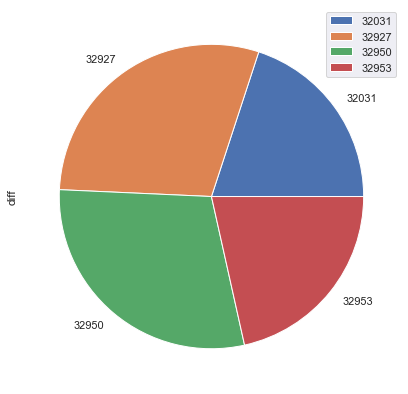

In [159]:
check['diff'].to_frame().query('diff>18000').plot.pie(y='diff', figsize=(7, 7));
#Степы которые многие посмотрели, но не стали дальше

### Найдем номер который многие пытались решить и именно после него бросили

In [160]:
an=submissions_data[submissions_data.submission_status == "wrong"].groupby(['user_id', 'step_id'], as_index=False)\
        .agg({'timestamp':'max'})

In [161]:
an=an.step_id.value_counts().sort_values(ascending=False).to_frame()
an.head()

,step_id
31978,3423
32031,3255
31972,3064
32202,2614
31971,2517


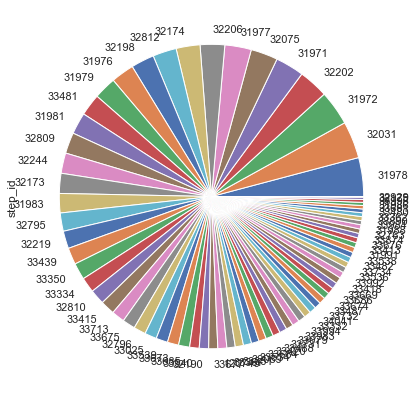

In [162]:
an.plot.pie(y='step_id', figsize=(7, 7),legend=False);

In [163]:
a=an.idxmax()
print('Cтеп номер ',a[0])

Cтеп номер  31978


Преобразуем так же данные со второй таблицей, отобрав лишь где прошло не более 3 дней с начала прохождений

In [164]:
submissions_data['user_time'] =submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str) 

In [165]:
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='inner')

In [166]:
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [167]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_threshold
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177
...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,2615_1501946959,2615_1502205860
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,13177_1503059927,13177_1503314487
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,15253_1506348153,15253_1506606463
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1424_1523035316,1424_1523294469


In [168]:
events_data_train.groupby('user_id').day.nunique().max()

4

### Создадим из данных по 3 дня фичи для машинного обучения

In [169]:
X=events_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
                        .rename(columns={'day':'days'})
# Задали значения числа дней захода за этот период (от 1 до 4 значения бывают)

In [170]:
steps_tried=submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
                        .rename(columns={'step_id':'steps_tried'})
# Задали значения пройденых степов за этот период 

In [171]:
X=X.merge(steps_tried)

In [172]:
X=X.merge(submissions_data_train.pivot_table(index='user_id',columns='submission_status',
                                 values='step_id', aggfunc='count',fill_value=0).reset_index())

In [173]:
X['correct_ratio']=X.correct/(X.correct+X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [174]:
X=X.merge(events_data_train.pivot_table(index='user_id',columns='action',
                                 values='step_id', aggfunc='count',fill_value=0)\
                                      .reset_index()[['user_id','viewed']],how='outer')
X=X.fillna(0)

In [175]:
X=X.merge(users_data[['user_id','passed_course','is_gone_user']],how='outer')

In [176]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [177]:
X=X[~((X.is_gone_user == False) & (X.passed_course==False))]
# Тем самым найдем тех, кто уже не в процессе решения кура, а кто точно имеет тот или иной статус

### Задаем значения для ML

In [178]:
y=X.passed_course
X=X.drop(['passed_course','is_gone_user'],axis=1)

In [179]:
X=X.set_index(X.user_id)
X=X.drop('user_id',axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [180]:
y=y.map(int)
y.head(7)

0    0
1    0
2    0
3    0
4    1
5    0
6    1
Name: passed_course, dtype: int64

## Tree без и с кросс-валидацией

In [181]:
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [182]:
# Импортируем модули, необходимые для визуализации дерева решений.
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [184]:
# Зададим диапазон исследуемых значений.
max_depth_values = range(1, 51)
scores_iris_data = pd.DataFrame()
rs = np.random.seed(0)
scores_data=pd.DataFrame()

for max_depth in max_depth_values:
    # Изменяем глубину обучения дерева по циклу от 1 до 99 с шагом 1.
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rs)
    # Обучаем дерево решений (с ограниченной глубиной) на подмножестве train.
    clf.fit(X_train, y_train)
    # Записываем в отдельную переменную число правильных ответов на обученной модели дерева
    train_score = clf.score(X_train, y_train)
    No_validation_score=clf.score(X_test, y_test)
    # Записываем в отдельную переменную число правильных ответов на обученной модели дерева
    test_val_score = cross_val_score(clf,X_train,y_train,cv=5).mean()
    # Создаем временный DataFrame.
    temp_score_data = pd.DataFrame({'max_depth':[max_depth],
                                         'Train_score':[train_score],
                                          'No_validation_score':[No_validation_score],  
                                           'Validation_score':[test_val_score]})
    # Наращиваем DataFrame "scores_iris_data".
    scores_data = scores_data.append(temp_score_data)
scores_data.head(10)

,max_depth,Train_score,No_validation_score,Validation_score
0,1,0.913458,0.923333,0.913458
0,2,0.913458,0.923333,0.913458
0,3,0.917968,0.925926,0.917642
0,4,0.917968,0.925926,0.918034
0,5,0.918949,0.925926,0.917969
0,6,0.920125,0.923333,0.917707
0,7,0.921106,0.921111,0.915223
0,8,0.922805,0.922222,0.914766
0,9,0.925681,0.923704,0.912086
0,10,0.928754,0.922593,0.910125


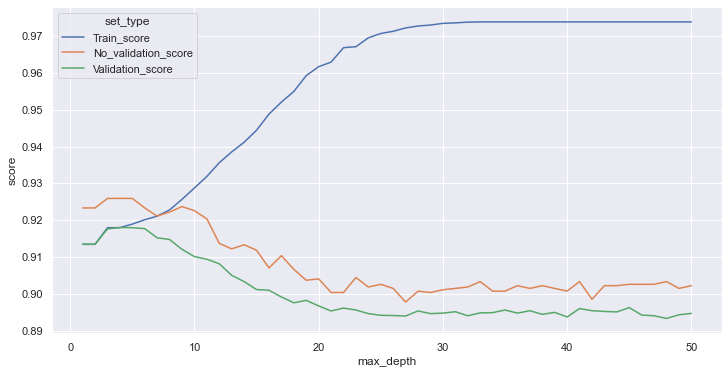

In [185]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars=['Train_score','No_validation_score','Validation_score'],
                           var_name='set_type', value_name='score')
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long);

In [186]:
#Подбор лучших параметров:
from sklearn.model_selection import GridSearchCV
par={'max_depth':range(1,8),'min_samples_split':range(2,6)
     , 'min_samples_leaf':range(2,6)}
search=GridSearchCV(clf,par,cv=5)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

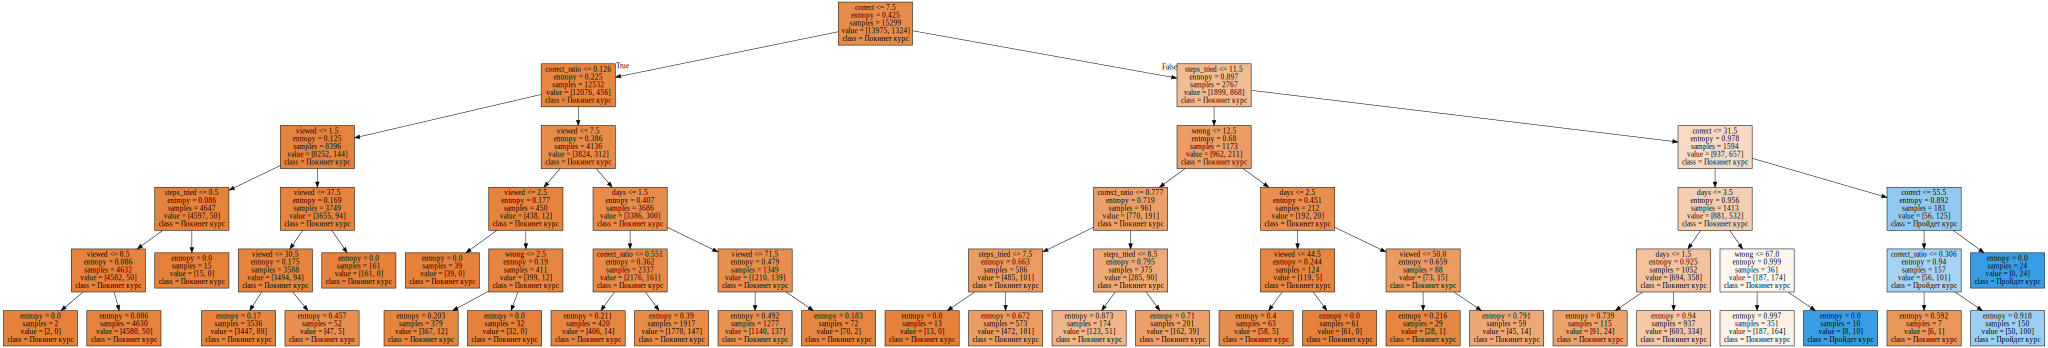

In [187]:
best_tree=search.best_estimator_
clf_best=best_tree
graph=Source(tree.export_graphviz(best_tree,out_file=None
                                  , feature_names=list(X_train)
                                  , class_names=['Покинет курс','Пройдет курс']
                                  , filled=True)) 
display(SVG(graph.pipe(format='svg')))

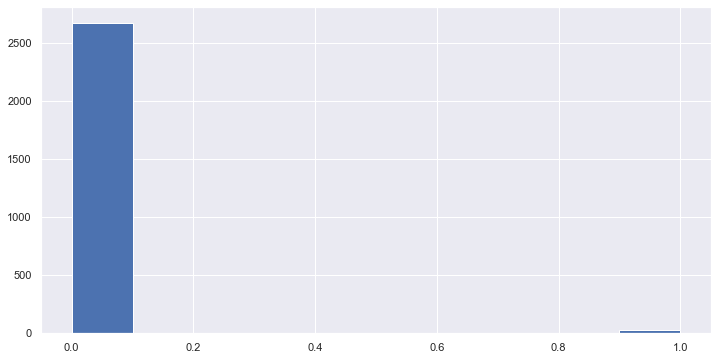

In [188]:
y_pred=best_tree.predict_proba(X_test)
y_pred_class=best_tree.predict(X_test)
pd.Series(y_pred_class).hist();

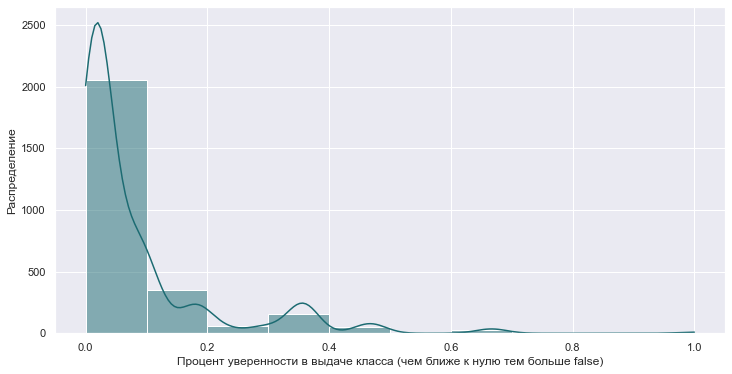

In [189]:
ax = sns.histplot(pd.Series(y_pred[:,1]),bins=10, kde=True,color='#1c6b72')
ax.set_xlabel('Процент уверенности в выдаче класса (чем ближе к нулю тем больше false)')
ax.set_ylabel('Распределение');

Мы хотим большее число людей считать оставшимися на курсе чтобы быть наверняка уверенным, что тот, кого мы нашли однозначно покинет курс. Так что сместим границу уверенности от 50% до 20%

Наша цель- увеличить recall (то есть увеличить уверенность, что все те, кто пройдут будут обнаружены)

In [190]:
from sklearn.metrics import recall_score, precision_score

In [191]:
clf_best.score(X_test,y_test)

0.9259259259259259

In [192]:
recall_score(y_test,y_pred_class)

0.08695652173913043

In [193]:
y_pred_class_new=np.where(y_pred[:,1]>0.1,1,0)

In [194]:
recall_score(y_test,y_pred_class_new)

0.7342995169082126

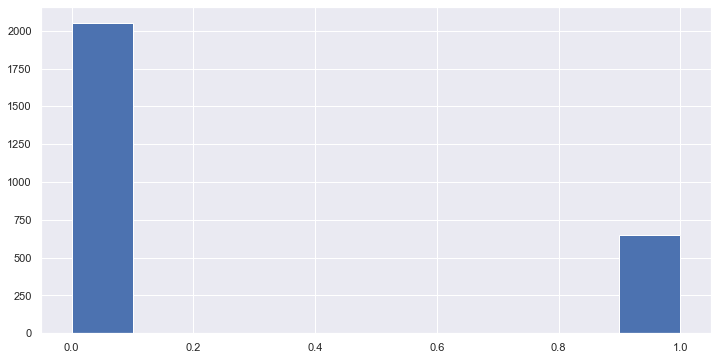

In [195]:
pd.Series(y_pred_class_new).hist();

### Создадим Random Forest

In [196]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=0)
par={'n_estimators':range(6,11),'max_depth':range(3,10),'min_samples_split':range(2,7)
     , 'min_samples_leaf':range(1,5)}
search=GridSearchCV(clf,par,cv=5,n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 8}

Произвели поиск лучших параметров

In [197]:
clf_best=search.best_estimator_
feature_importances=clf_best.feature_importances_
clf_best.fit(X_train, y_train)
feature_importance_df=pd.DataFrame({'featured':list(X_train),
                                    'feature_importances':feature_importances})
feature_importance_df.sort_values('feature_importances',ascending=False)

,featured,feature_importances
2,correct,0.398751
1,steps_tried,0.194674
3,wrong,0.135144
5,viewed,0.097308
0,days,0.088401
4,correct_ratio,0.085721


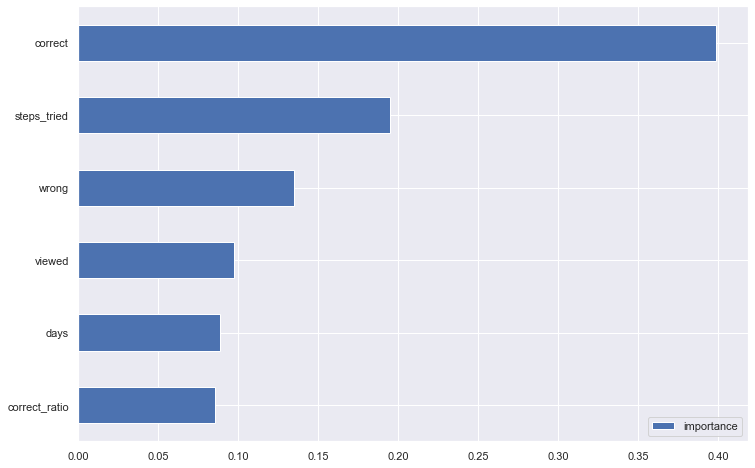

In [198]:
imp = pd.DataFrame(clf_best.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

Мы определили самые значимыйе параметры в разработанной модели. Ими оказалось значение правильно решенных номеров за первые 3 дня прохождения курса и значение числа попыток решить степы

Определим зачение accuracy полученное с помошью random forest:

In [199]:
clf_best.score(X_test,y_test)

0.9274074074074075

Опять определим параметр recall:

In [200]:
recall_score(y_test,y_pred_class)

0.08695652173913043

In [201]:
y_pred=clf_best.predict_proba(X_test)
y_pred_class=clf_best.predict(X_test)

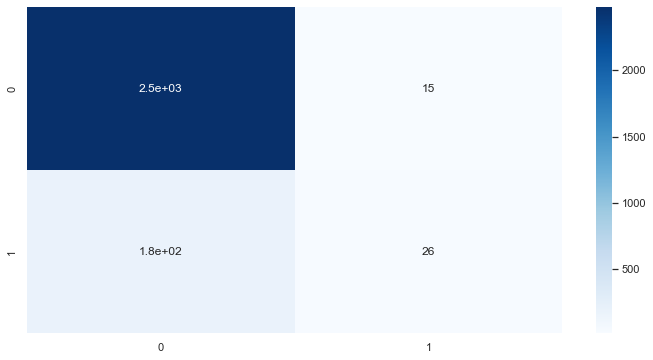

In [202]:
mat=confusion_matrix(y_test, y_pred_class)
sns.heatmap(mat,annot=True,cmap='Blues');

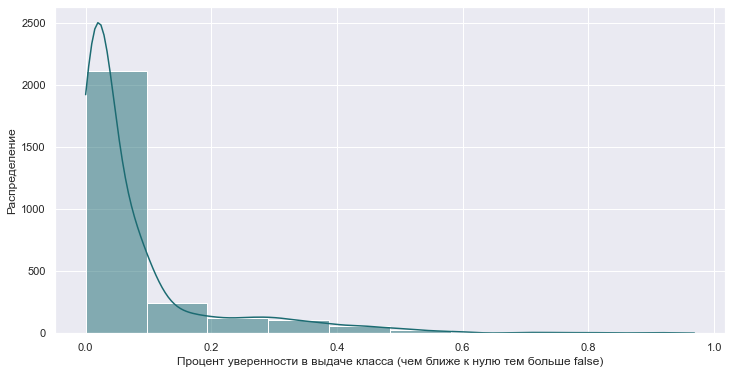

In [203]:
ax = sns.histplot(pd.Series(y_pred[:,1]),bins=10, kde=True,color='#1c6b72')
ax.set_xlabel('Процент уверенности в выдаче класса (чем ближе к нулю тем больше false)')
ax.set_ylabel('Распределение');

In [204]:
y_pred_class_new=np.where(y_pred[:,1]>0.1,1,0)

In [205]:
recall_score(y_test,y_pred_class_new)

0.7004830917874396

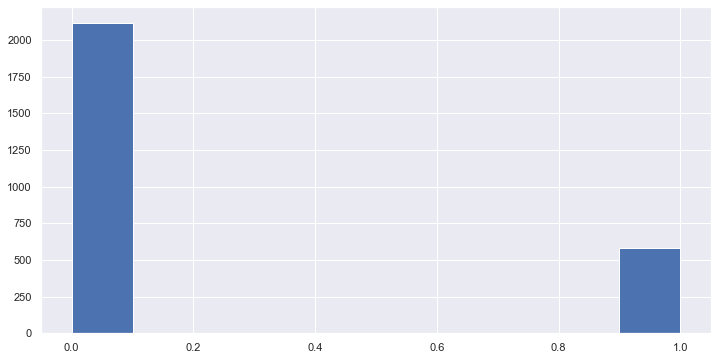

In [206]:
pd.Series(y_pred_class_new).hist();

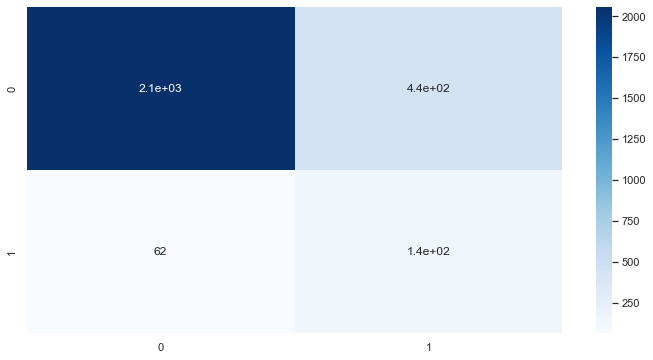

In [207]:
mat=confusion_matrix(y_test,y_pred_class_new)
sns.heatmap(mat,annot=True,cmap='Blues');

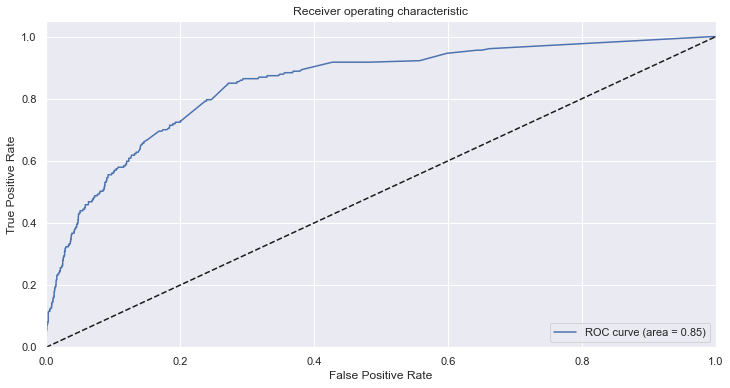

In [208]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

**Общий вывод:**

Благодаря смещению границы мы смогли значительо повысить recall. Это позволяет с высокой степенью вероятности быть убежденным, что среди определенных пользователей точно будут почти все те, кто пройдут курс до конца. Эо позволит придумать сопооб для более персонального взаимодействия с аудиторией. По результату исследования видно, что метод рандомных деревьев лучше всего справился с задачей поиска потенциальных окончателей курса. При этом выбранные пользователи с высоким шансом прохждения составляют менее одной пятой обего числа записавшихся на курс. В процссе иследования positive классом считался класс потенциальных окончателей курса на степике.